In [1]:
%run -i model.ipynb

100%|██████████| 10000/10000 [00:05<00:00, 1854.21it/s]


<Figure size 640x480 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

## Traditional GP optimization with `Pyro`

In [2]:
import pyro.contrib.gp as gp
from torch.distributions import constraints, transform_to
import torch.autograd as autograd
import torch.optim as optim

In [3]:
X = torch.tensor([[50.]])
conditioned_y_sample = poutine.condition(y_sample, data={"mu": X})
y = R(conditioned_y_sample()).view(1)

gpmodel = gp.models.GPRegression(X=X, 
                                 y=y, 
                                 kernel=gp.kernels.Product(gp.kernels.RBF(input_dim=1), gp.kernels.Cosine(input_dim=1)),
                                 noise=torch.tensor(1.), 
                                 jitter=1.0e-4)

In [4]:
def update_posterior(x):
    conditioned_y_sample = poutine.condition(y_sample, data={"mu": x})
    y = R(conditioned_y_sample()).view(x.size(0))
    
    X = torch.cat([gpmodel.X, x])
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=1e-4)
    gp.util.train(gpmodel, optimizer)

In [ ]:
def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

In [ ]:
def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

In [ ]:
def next_x(lower_bound=-100, upper_bound=100, num_candidates=5):
    candidates = []
    values = []

    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new_empty(1, 1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

In [ ]:
update_posterior(next_x())

In [ ]:
def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        # plot the acquisition function
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    ax2.set_xlim(-0.1, 1.1)
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.legend(loc=1)

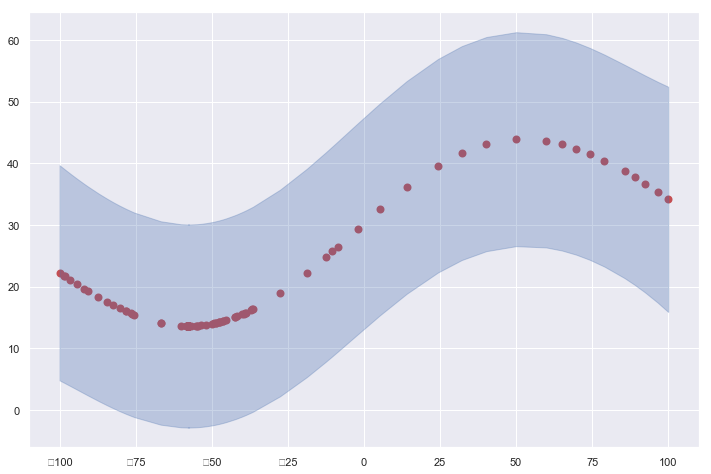

 61%|██████    | 305/500 [3:04:20<6:46:05, 124.95s/it]

In [ ]:
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
N = 500

optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)
for i in tqdm.tqdm(range(N)):
    xmin = next_x()
    update_posterior(xmin)
    clear_output()
    
    plt.figure(figsize=(12, 8))
    X = gpmodel.X
    
    X, _ = torch.sort(X, dim=0)
    loc, var = gpmodel(X, full_cov=False, noiseless=False)
    sd = var.sqrt()
    plt.scatter(X.detach().numpy().ravel(), loc.detach().numpy(), c="r", lw=2)  # plot predictive mean
    plt.fill_between(X.detach().numpy().ravel(), 
                     loc.detach().numpy() - 2*sd.detach().numpy(), 
                     loc.detach().numpy() + 2*sd.detach().numpy(),
                     color="C0", alpha=0.3)  # plot uncertainty intervals
    plt.show()


In [ ]:
plt.figure(figsize=(12, 8))
X = gpmodel.X

X, _ = torch.sort(X, dim=0)
loc, var = gpmodel(X, full_cov=False, noiseless=False)
sd = var.sqrt()
plt.scatter(X.detach().numpy().ravel(), loc.detach().numpy(), c="r", lw=2)  # plot predictive mean
plt.fill_between(X.detach().numpy().ravel(), 
                 loc.detach().numpy() - 2*sd.detach().numpy(), 
                 loc.detach().numpy() + 2*sd.detach().numpy(),
                 color="C0", alpha=0.3)  # plot uncertainty intervals
plt.show()

In [ ]:
gpmodel.y.min()